# 20190925 Ratiometric cross-talk separation failure

## Goal
* analyze why it seems the ratiometric cross-talk separation system won't work

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
sns.set_context('poster')

In [ ]:
# Create Hill function, function; takes vector of inputs, returns vector of outputs
def hill(x_vals, y_min = 0.005, y_max = 1, kd = 1, n = 2):
    outputs = []
    for x in x_vals:
        out =  y_min+((y_max-y_min)/(1+(kd/x)**n))
        outputs.append(out)
    return np.array(outputs)

## Ratiometric circuit simulation

Semi-quantitative simulation of ratiometric circuit

In [ ]:
def ratio_circ(inputs_1, inputs_2, kd_kr_ratio = 1, n =0.7, a = 1):
    
    kr = 0.001/30/(2.9*10**(-3))
    kd = kd_kr_ratio*kr
    scale = 7*a
    
    pairs = list(zip(inputs_1,inputs_2))
    
    output = []
    for pair in pairs:
        out = scale*(1/(1+pair[0]**n/kd + pair[1]**n/kr) + 1/(1+kd/pair[0]**n + pair[1]**n*kd/(pair[0]**n*kr)))
        output.append(out)
    return np.array(output)

### Relationship b/w derepression gRNA binding constant and ratiometric output

In [ ]:
# Makes pairs of inputs from sets
def pair_maker(inputs_1,inputs_2):
    pairs = []
    for i in inputs_1:
        for j in inputs_2:
            pairs.append((i,j))
    return pairs

# make a log-spaced set of inputs and make full grid out of them
inputs = np.logspace(-2,1,50)*100
pairs = np.array(pair_maker(inputs,inputs))
real_ratios = pairs[:,0]/pairs[:,1]

# Calculate for 3 different binding strengths of derep gRNA
outputs_same_k = ratio_circ(pairs[:,0],pairs[:,1], kd_kr_ratio=1, a = 1)
outputs_high_k = ratio_circ(pairs[:,0],pairs[:,1], kd_kr_ratio=10, a = 1)
outputs_v_high_k = ratio_circ(pairs[:,0],pairs[:,1], kd_kr_ratio=100, a = 10)

In [ ]:
fig, ax = plt.subplots(2,3)

for i in range(2):
    ax[i,0].scatter(real_ratios,outputs_same_k,s =20)
    ax[i,0].set_ylabel('Predicted circuit output')

    ax[i,1].scatter(real_ratios,outputs_high_k,s =20)
    
    ax[i,2].scatter(real_ratios,outputs_v_high_k,s =20)
    

ax[0,0].set_title('$K_d = K_r$')
ax[0,1].set_title('$K_d = 10*K_r$')
ax[0,2].set_title('$K_d = 100*K_r$')
    
for i in range(3):
    ax[0,i].set_xscale('log')
    ax[0,i].set_yscale('log')
    ax[0,i].set_xlim([0.0001,1000])
    ax[0,i].set_ylim([0.001,10])
    
    ax[1,i].set_yscale('linear')
    ax[1,i].set_ylim([0,8])
    ax[1,i].set_xlim([0,100])
    ax[1,i].set_xlabel('Real ratio input')

fig.set_size_inches(15,10)

Increasing the K_d expands the range and seems to roughly reflect experimental data (when $K_d = K_r$)
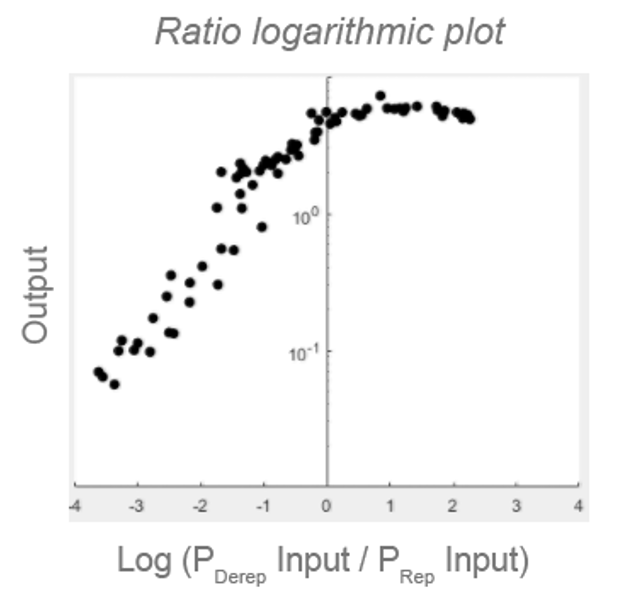

## Simulating w/ Adam's QS data

In [ ]:
# Calculates fold difference and ensures its positive by always dividing larger number by smaller number
def pos_fold_calc(a_out,b_out):
    a_out = np.array(a_out)
    b_out = np.array(b_out)
    calc_out = np.zeros(a_out.shape)
    
    # Figure out terms of a that are greater than b
    a_gt_b = np.greater(a_out,b_out)
    
    i = 0
    for i in range(0,calc_out.shape[0]):
        # if a > b for that component. divide a/b; otherwise, divide b/a
        if a_gt_b[i]:
            calc_out[i] = a_out[i] / b_out[i]
        else:
            calc_out[i] = b_out[i] / a_out[i]
        i = i + 1
    return calc_out

In [ ]:
# Big ass plotting function that plots original sensor transfer functions, and ratiometrically "resolved" ones
def plt_2p_2in(xs, hill_fn_dict,high_kd_scale = 1, ratio_n = 1, a = 1):    
    
    # Promoter 1 response
    # Inducer A
    p1a = hill_fn_dict['P1'][0]
    # Inducer B
    p1b = hill_fn_dict['P1'][1]

    # Promoter 2 response
    # Inducer a
    p2a = hill_fn_dict['P2'][0]
    # Inducer b
    p2b = hill_fn_dict['P2'][1]

    # Calculating real ratios
    p1p2ratios = {'A': [], 'B': []}
    p2p1ratios = {'A': [], 'B': []}

    p1p2ratios['A'] = p1a/p2a
    p2p1ratios['A'] = p2a/p1a
    p1p2ratios['B'] = p1b/p2b
    p2p1ratios['B'] = p2b/p1b
    
    # Calculate results through simulated ratiometric circuit w/ high and low ratio capabilities
    p1p2ratios_low = {'A': [], 'B': []}
    p2p1ratios_low = {'A': [], 'B': []}
    
    p1p2ratios_high = {'A': [], 'B': []}
    p2p1ratios_high = {'A': [], 'B': []}
    
        # Calculate for low ratio circuit
    p1p2ratios_low['A'] = ratio_circ(p1a,p2a)
    p1p2ratios_low['B'] = ratio_circ(p1b,p2b)
    p2p1ratios_low['A'] = ratio_circ(p2a,p1a)
    p2p1ratios_low['B'] = ratio_circ(p2b,p1b)
    
        # Calculate for high ratio circuit    
    p1p2ratios_high['A'] = ratio_circ(p1a,p2a, kd_kr_ratio=high_kd_scale, n = ratio_n, a = a)
    p1p2ratios_high['B'] = ratio_circ(p1b,p2b, kd_kr_ratio=high_kd_scale, n = ratio_n, a = a)
    p2p1ratios_high['A'] = ratio_circ(p2a,p1a, kd_kr_ratio=high_kd_scale, n = ratio_n, a = a)
    p2p1ratios_high['B'] = ratio_circ(p2b,p1b, kd_kr_ratio=high_kd_scale, n = ratio_n, a = a)
    
    # Fold difference calculations
    # Calculate separation with just single promoters
    p1fold = pos_fold_calc(p1a,p1b)
    p2fold = pos_fold_calc(p2a,p2b)
    
    # Calculate fold-separation between different inducers for ratiometric systems
    ratiofold = pos_fold_calc(p1p2ratios['A'],p1p2ratios['B'])
    ratiofold_low = pos_fold_calc(p1p2ratios_low['A'],p1p2ratios_low['B'])
    ratiofold_high = pos_fold_calc(p1p2ratios_high['A'],p1p2ratios_high['B'])
        
    # Plotting
    # Plot it all
    fig, axes = plt.subplots(5,2,sharey=False, sharex = False)

    #p1
    axes[0,0].plot(xs,p1a,color = "#984ea3", linewidth=5)
    axes[0,0].plot(xs,p1b, color="#377eb8",linewidth=5)
    axes[0,0].set_ylim([0.005,5])
    axes[0,0].set_title('P1')

    #p2
    axes[0,1].plot(xs,p2a,color = "#984ea3", linewidth=5)
    axes[0,1].plot(xs,p2b,color="#377eb8",linewidth=5)
    axes[0,1].set_ylim([0.005,5])
    axes[0,1].set_title('P2')

    #p1/p2
    axes[1,0].plot(xs,p1p2ratios['A'],color = "#984ea3", linewidth=5)
    axes[1,0].plot(xs,p1p2ratios['B'],color="#377eb8",linewidth=5)
    axes[1,0].set_ylim([0.01,100])
    axes[1,0].set_ylabel('Real Ratio')
    axes[1,0].set_title('P1/P2')

    #p2/p1
    axes[1,1].plot(xs,p2p1ratios['A'],color = "#984ea3", linewidth=5)
    axes[1,1].plot(xs,p2p1ratios['B'],color="#377eb8",linewidth=5)
    axes[1,1].set_ylim([0.01,100])
    axes[1,1].set_ylabel('Real Ratio')
    axes[1,1].set_title('P2/P1')
    
    #p1/p2 low ratio
    axes[2,0].plot(xs,p1p2ratios_low['A'],color = "#984ea3", linewidth=5)
    axes[2,0].plot(xs,p1p2ratios_low['B'],color="#377eb8",linewidth=5)
    axes[2,0].set_ylim([0.01,100])
    axes[2,0].set_ylabel('Ratiometric circuit output')
    axes[2,0].set_title('P1/P2, low ratio')
    
    #p2/p1 low ratio
    
    axes[2,1].plot(xs,p2p1ratios_low['A'],color = "#984ea3", linewidth=5)
    axes[2,1].plot(xs,p2p1ratios_low['B'],color="#377eb8",linewidth=5)
    axes[2,1].set_ylim([0.01,100])
    axes[2,1].set_ylabel('Ratiometric circuit output')
    axes[2,1].set_title('P2/P1, low ratio')
    
    #p1/p2 high ratio
    
    axes[3,0].plot(xs,p1p2ratios_high['A'],color = "#984ea3", linewidth=5)
    axes[3,0].plot(xs,p1p2ratios_high['B'],color="#377eb8",linewidth=5)
    axes[3,0].set_ylim([0.01,100])
    axes[3,0].set_ylabel('Ratiometric circuit output')
    axes[3,0].set_title('P1/P2, high ratio')
    
    #p2/p1 high ratio
    
    axes[3,1].plot(xs,p2p1ratios_low['A'],color = "#984ea3", linewidth=5)
    axes[3,1].plot(xs,p2p1ratios_low['B'],color="#377eb8",linewidth=5)
    axes[3,1].set_ylim([0.01,100])
    axes[3,1].set_ylabel('Ratiometric circuit output')
    axes[3,1].set_title('P2/P1, high ratio')
    
    # fold differences for p1 only, p2 only, and real ratios
    axes[4,0].plot(xs,p1fold, color='#984ea3', linewidth = 5)
    axes[4,0].plot(xs,p2fold, color='#377eb8', linewidth = 5)
    axes[4,0].plot(xs,ratiofold, color='#000000', linewidth = 5)
    axes[4,0].legend(['P1 only', 'P2 only', 'Ratio'])
    axes[4,0].set_yscale('log')
    axes[4,0].set_xscale('log')
    axes[4,0].set_xlabel('Input')
    axes[4,0].set_ylabel('Fold-difference')
    axes[4,0].set_title('Fold separation w/ ideal ratio')
    
    # fold differences for p1 only, p2 only, and ratios through circuit
    axes[4,1].plot(xs,p1fold, color='#984ea3', linewidth = 5)
    axes[4,1].plot(xs,p2fold, color='#377eb8', linewidth = 5)
    axes[4,1].plot(xs,ratiofold_low, color='#000000', linewidth = 5)
    axes[4,1].plot(xs,ratiofold_high, color='#C4C4C4', linewidth = 5)
    axes[4,1].legend(['P1 only', 'P2 only', '$K_d=K_r$', '$K_d={} K_r$'.format(high_kd_scale)])
    axes[4,1].set_yscale('log')
    axes[4,1].set_xscale('log')
    axes[4,1].set_xlabel('Input')
    axes[4,1].set_ylabel('Fold-difference')
    axes[4,1].set_title('Fold separation w/ real circuit')
    

    for i in [0,1,2,3]:
        for j in [0,1]:
            axes[i,j].set_xscale('log')
            axes[i,j].set_yscale('log')
            axes[i,j].set_xlabel('Input')
            if i != 1:
                axes[i,j].set_ylabel('Output')
            axes[i,j].legend(['A','B'])

    sns.despine()

    fig.set_size_inches(15,25)
    fig.tight_layout()
    fig.subplots_adjust(hspace = 1)

### CinR / LasRQ simulations
* attempt to simulate the transfer functions for CinR / LasRQ promoters from Adam's data
* P1 = CinR promoter
* P2 = LasRQ promoter
* Inducer A = CinR ligand
* Inducer B = LasRQ ligand

In [ ]:
# Inducer A, then Inducer B for each promoter
xs = np.logspace(-7,0,100)
hill_fx = {
    'P1':[hill(xs, y_min = 0.02, y_max = 2, kd = 2*10**(-5), n = 2), 
          hill(xs, y_min = 0.01, y_max = 1, kd = 4*10**(-2), n = 2)],
    'P2':[hill(xs, y_min = 0.03, y_max = 1, kd = 9*10**(-2), n = 1), 
          hill(xs, y_min = 0.03, y_max = 2, kd = 7*10**(-4), n = 1)]
}

### Effect of dCas9 cooperativity

#### n = 0.7 (normal rep/derep system)

In [ ]:
plt_2p_2in(xs,hill_fx,high_kd_scale=10, ratio_n = 0.7)

#### n = 2

In [ ]:
plt_2p_2in(xs,hill_fx,high_kd_scale=10, ratio_n = 2)

### Effect of binding strength difference

#### $K_d = 10K_r$

In [ ]:
plt_2p_2in(xs,hill_fx,high_kd_scale=10, ratio_n = 0.7)

#### $K_d = 100K_r$

In [ ]:
plt_2p_2in(xs,hill_fx,high_kd_scale=100, ratio_n = 0.7)

Higher $K_d$ differential doesn't seem to make a difference at low n.

### Binding strength differential, high n

In [ ]:
plt_2p_2in(xs,hill_fx,high_kd_scale=10, ratio_n = 2)

In [ ]:
plt_2p_2in(xs,hill_fx,high_kd_scale=100, ratio_n = 2)

#### Conclusions on binding strength differential and high ratio circuits
* high ratio circuits do provide some benefits to the system
* but cooperativity is what is needed to make it really work

## Amplifier
* try amplifying the output of the circuit, to make it better

In [ ]:
plt_2p_2in(xs,hill_fx,high_kd_scale=10, ratio_n = 0.7, a = 66)

## Overall conclusions
* the main issue seems to be that the ratiometric circuit has a shallow slope (because of the low cooperativity of dCas9)
* shallow slope along with the saturation point removes the dynamic range gained by taking ratios of circuits
* high ratio circuits show some benefit, but suffer from lower slope
    * if slope of high ratio circuits can be increased, it could be useful

# Looking at "information content"

In [ ]:
# Big ass plotting function that plots original sensor transfer functions, and ratiometrically "resolved" ones
def plt_2p_2in_inv(xs, hill_fn_dict,high_kd_scale = 1, ratio_n = 1, a = 1):    
    
    # Promoter 1 response
    # Inducer A
    p1a = hill_fn_dict['P1'][0]
    # Inducer B
    p1b = hill_fn_dict['P1'][1]

    # Promoter 2 response
    # Inducer a
    p2a = hill_fn_dict['P2'][0]
    # Inducer b
    p2b = hill_fn_dict['P2'][1]

    # Calculating real ratios
    p1p2ratios = {'A': [], 'B': []}
    p2p1ratios = {'A': [], 'B': []}

    p1p2ratios['A'] = p1a/p2a
    p2p1ratios['A'] = p2a/p1a
    p1p2ratios['B'] = p1b/p2b
    p2p1ratios['B'] = p2b/p1b
    
    # Calculate results through simulated ratiometric circuit w/ high and low ratio capabilities
    p1p2ratios_low = {'A': [], 'B': []}
    p2p1ratios_low = {'A': [], 'B': []}
    
    p1p2ratios_high = {'A': [], 'B': []}
    p2p1ratios_high = {'A': [], 'B': []}
    
        # Calculate for low ratio circuit
    p1p2ratios_low['A'] = ratio_circ(p1a,p2a)
    p1p2ratios_low['B'] = ratio_circ(p1b,p2b)
    p2p1ratios_low['A'] = ratio_circ(p2a,p1a)
    p2p1ratios_low['B'] = ratio_circ(p2b,p1b)
    
        # Calculate for high ratio circuit    
    p1p2ratios_high['A'] = ratio_circ(p1a,p2a, kd_kr_ratio=high_kd_scale, n = ratio_n, a = a)
    p1p2ratios_high['B'] = ratio_circ(p1b,p2b, kd_kr_ratio=high_kd_scale, n = ratio_n, a = a)
    p2p1ratios_high['A'] = ratio_circ(p2a,p1a, kd_kr_ratio=high_kd_scale, n = ratio_n, a = a)
    p2p1ratios_high['B'] = ratio_circ(p2b,p1b, kd_kr_ratio=high_kd_scale, n = ratio_n, a = a)
    
        
    # Plotting
    # Plot it all
    fig, axes = plt.subplots(6,2,sharey=False, sharex = False)

    #p1
    axes[0,0].plot(xs,p1a,color = "#984ea3", linewidth=5)
    axes[0,0].plot(xs,p1b, color="#377eb8",linewidth=5)
    axes[0,0].set_ylim([0.005,5])
    axes[0,0].set_title('P1')

    #p2
    axes[0,1].plot(xs,p2a,color = "#984ea3", linewidth=5)
    axes[0,1].plot(xs,p2b,color="#377eb8",linewidth=5)
    axes[0,1].set_ylim([0.005,5])
    axes[0,1].set_title('P2')

    #p1/p2
    axes[1,0].plot(xs,p1p2ratios['A'],color = "#984ea3", linewidth=5)
    axes[1,0].plot(xs,p1p2ratios['B'],color="#377eb8",linewidth=5)
    axes[1,0].set_ylim([0.01,100])
    axes[1,0].set_ylabel('Real Ratio')
    axes[1,0].set_title('P1/P2')

    #p2/p1
    axes[1,1].plot(xs,p2p1ratios['A'],color = "#984ea3", linewidth=5)
    axes[1,1].plot(xs,p2p1ratios['B'],color="#377eb8",linewidth=5)
    axes[1,1].set_ylim([0.01,100])
    axes[1,1].set_ylabel('Real Ratio')
    axes[1,1].set_title('P2/P1')
    
    #p1/p2 low ratio
    axes[2,0].plot(xs,p1p2ratios_low['A'],color = "#984ea3", linewidth=5)
    axes[2,0].plot(xs,p1p2ratios_low['B'],color="#377eb8",linewidth=5)
    axes[2,0].set_ylim([0.01,100])
    axes[2,0].set_ylabel('Ratiometric circuit output')
    axes[2,0].set_title('P1/P2, low ratio')
    
    #p2/p1 low ratio
    
    axes[2,1].plot(xs,p2p1ratios_low['A'],color = "#984ea3", linewidth=5)
    axes[2,1].plot(xs,p2p1ratios_low['B'],color="#377eb8",linewidth=5)
    axes[2,1].set_ylim([0.01,100])
    axes[2,1].set_ylabel('Ratiometric circuit output')
    axes[2,1].set_title('P2/P1, low ratio')
    
    #p1/p2 high ratio
    
    axes[3,0].plot(xs,p1p2ratios_high['A'],color = "#984ea3", linewidth=5)
    axes[3,0].plot(xs,p1p2ratios_high['B'],color="#377eb8",linewidth=5)
    axes[3,0].set_ylim([0.01,100])
    axes[3,0].set_ylabel('Ratiometric circuit output')
    axes[3,0].set_title('P1/P2, high ratio')
    
    #p2/p1 high ratio
    
    axes[3,1].plot(xs,p2p1ratios_low['A'],color = "#984ea3", linewidth=5)
    axes[3,1].plot(xs,p2p1ratios_low['B'],color="#377eb8",linewidth=5)
    axes[3,1].set_ylim([0.01,100])
    axes[3,1].set_ylabel('Ratiometric circuit output')
    axes[3,1].set_title('P2/P1, high ratio')
    
    #p1 inverse
    axes[4,0].plot(p1a,xs,color = "#984ea3", linewidth=5)
    axes[4,0].plot(p1b,xs, color="#377eb8",linewidth=5)
    axes[4,0].set_xlim([1e-3,10])
    axes[4,0].set_ylim([1e-7,1])
    axes[4,0].set_title('P1 inverse')

    #p2 inverse
    axes[4,1].plot(p2a,xs,color = "#984ea3", linewidth=5)
    axes[4,1].plot(p2b,xs, color="#377eb8",linewidth=5)
    axes[4,1].set_xlim([1e-3,10])
    axes[4,1].set_ylim([1e-7,1])
    axes[4,1].set_title('P2 inverse')
    
    #p1/p2 low ratio inverse
    axes[5,0].plot(p1p2ratios_low['A'],xs,color = "#984ea3", linewidth=5)
    axes[5,0].plot(p1p2ratios_low['B'],xs, color="#377eb8",linewidth=5)
    axes[5,0].set_xlim([1e-3,10])
    axes[5,0].set_ylim([1e-7,1])
    axes[5,0].set_title('P1/P2 low ratio inverse')

    #p1/p2 high ratio inverse
    axes[5,1].plot(p1p2ratios_high['A'],xs,color = "#984ea3", linewidth=5)
    axes[5,1].plot(p1p2ratios_high['B'],xs, color="#377eb8",linewidth=5)
    axes[5,1].set_xlim([1e-3,10])
    axes[5,1].set_ylim([1e-7,1])
    axes[5,1].set_title('P1/P2 high ratio inverse')
    

    for i in [0,1,2,3,4,5]:
        for j in [0,1]:
            axes[i,j].set_xscale('log')
            axes[i,j].set_yscale('log')
            axes[i,j].set_xlabel('Input')
            if i != 1:
                axes[i,j].set_ylabel('Output')
            axes[i,j].legend(['A','B'])
            
            if i in [4,5]:
                axes[i,j].set_xlabel('Output')
                axes[i,j].set_ylabel('Input')

    sns.despine()

    fig.set_size_inches(15,35)
    fig.tight_layout()
    fig.subplots_adjust(hspace = 1)

In [ ]:
plt_2p_2in_inv(xs,hill_fx,high_kd_scale=10, ratio_n = 0.7)

## Thoughts
* drawing vertical lines on the inverted curve gives you the possible input values for a given output value
* the single promoters alone have multiple inducers that cross the vertical lines
    * this means that you cannot differentiate whether or not A or B is present by looking at the output of a single promoter
* the ratio promoter output has strict separation between A and B for all input values
    * some are better than others of course